In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sklearn.svm

In [2]:
models = {
    'openclip ViT-B-16': dict(img_embeds=np.load('clip-embeddings/coco-embeds-open-clip-vit-b-16/img_emb/img_emb_0.npy'),
                              text_embeds=np.load('clip-embeddings/coco-embeds-open-clip-vit-b-16/text_emb/text_emb_0.npy')),
    
    'openclip ViT-B-32': dict(img_embeds=np.load('clip-embeddings/coco-embeds-open-clip-vit-b-32/img_emb/img_emb_0.npy'),
                              text_embeds=np.load('clip-embeddings/coco-embeds-open-clip-vit-b-32/text_emb/text_emb_0.npy')),

    'cloob ViT-B-16': dict(img_embeds=np.load('clip-embeddings/cloob-vit-b-16/cloob_laion_400m_vit_b_16_32_epochs_coco_train2017_image_embeds.npy'),
                           text_embeds=np.load('clip-embeddings/cloob-vit-b-16/cloob_laion_400m_vit_b_16_32_epochs_coco_train2017_text_embeds.npy')),
    
    'ml_jku_cloob_infoNCE': dict(img_embeds=np.load("clip-embeddings/ml_jku_cloob_embeddings/cloob_infoNCE_rn50_cc_epoch_128_image_embeds.npy"),
                            text_embeds=np.load("clip-embeddings/ml_jku_cloob_embeddings/cloob_infoNCE_rn50_cc_epoch_128_text_embeds.npy")),

    'ml_jku_clip_rn50': dict(img_embeds=np.load("clip-embeddings/ml_jku_cloob_embeddings/clip30_rn50_cc_epoch_128_image_embeds.npy"),
                        text_embeds=np.load("clip-embeddings/ml_jku_cloob_embeddings/clip30_rn50_cc_epoch_128_text_embeds.npy")),

    'ml_jku_clip_infoLOOB': dict(img_embeds=np.load("clip-embeddings/ml_jku_cloob_embeddings/clip_infoLOOB_rn50_cc_epoch_128_image_embeds.npy"),
                            text_embeds=np.load("clip-embeddings/ml_jku_cloob_embeddings/clip_infoLOOB_rn50_cc_epoch_128_text_embeds.npy")),

    'ml_jku_cloob_rn50': dict(img_embeds=np.load("clip-embeddings/ml_jku_cloob_embeddings/cloob_rn50_cc_epoch_128_image_embeds.npy"),
                         text_embeds=np.load("clip-embeddings/ml_jku_cloob_embeddings/cloob_rn50_cc_epoch_128_text_embeds.npy")),

}

In [3]:

def projected_dist(img_embed, text_embed):

    X = np.concatenate([img_embed, text_embed])
    y = np.concatenate([np.zeros(len(img_embed)), np.ones(len(text_embed))])
    xm, xstd = X.mean(axis=0), X.std(axis=0)
    
    svm = sklearn.svm.LinearSVC()
    svm.fit(X, y)
    
    
    w_norm = np.linalg.norm(svm.coef_)
    hyperplane_normal = svm.coef_ / w_norm
    projected = X - ((svm.decision_function(X)[:, None] / w_norm) - svm.intercept_) * hyperplane_normal

    projected_dist = np.linalg.norm(projected[:len(img_embed)] - projected[len(text_embed):], axis=-1)
    return projected_dist.mean(), projected_dist.std()

import seaborn
from tqdm import tqdm
import pandas

results = pandas.DataFrame([
    {"name": name, "projected_dist": projected_dist(model["img_embeds"], model["text_embeds"])[0] }
    for model, name in tqdm([(models['openclip ViT-B-32'], "CLIP ViT-B/32"),
                     (models['openclip ViT-B-16'], "CLIP ViT-B/16"),
                     (models['cloob ViT-B-16'], "CLOOB ViT-B/16"),
                     (models['ml_jku_cloob_infoNCE'], "CLOOB infoNCE RN50"),
                     (models['ml_jku_clip_rn50'], "CLIP RN50"),
                     (models['ml_jku_clip_infoLOOB'], "CLIP infoLOOB RN50"),
                     (models['ml_jku_cloob_rn50'], "CLOOB RN50")])
])



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:25<00:00, 12.27s/it]


In [4]:
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

<AxesSubplot:xlabel='name', ylabel='projected_dist'>

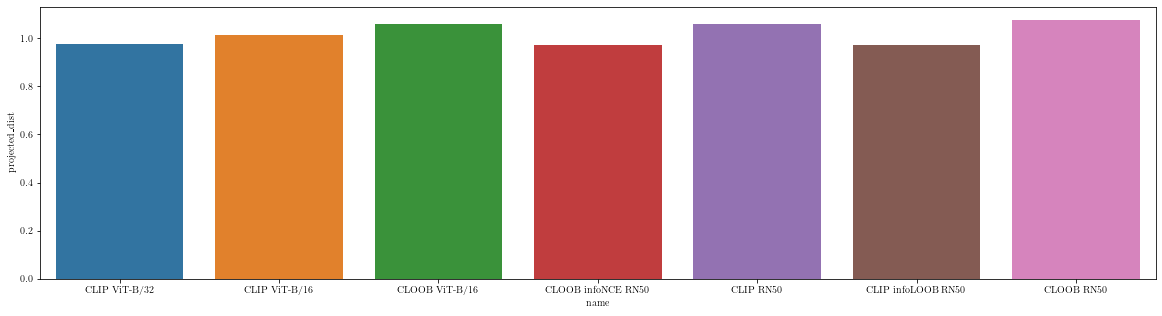

In [5]:
plt.figure(figsize=(20, 5), facecolor="white")
seaborn.barplot(data=results, x="name", y="projected_dist")

In [10]:
from umap import UMAP

def projected_embed(img_embeds, text_embeds):

    X = np.concatenate([img_embeds, text_embeds], axis=0)
    y = np.concatenate([np.zeros(len(img_embeds)), np.ones(len(text_embeds))])
    
    umap = UMAP().fit_transform(X)
    
    xm, xstd = X.mean(axis=0), X.std(axis=0)
    
    svm = sklearn.svm.LinearSVC()
    svm.fit(X, y)
    
    
    w_norm = np.linalg.norm(svm.coef_)
    hyperplane_normal = svm.coef_ / w_norm
    projected = X - ((svm.decision_function(X)[:, None] / w_norm) - svm.intercept_) * hyperplane_normal
    
    u_after = UMAP().fit_transform(projected)
    return umap, u_after

img_embeds, text_embeds = models["openclip ViT-B-16"]["img_embeds"][:5000], models["openclip ViT-B-16"]["text_embeds"][:5000]
umap, u_after = projected_embed(img_embeds, text_embeds)

Text(0.5, 0.95, 'CLIP ViT-B/16')

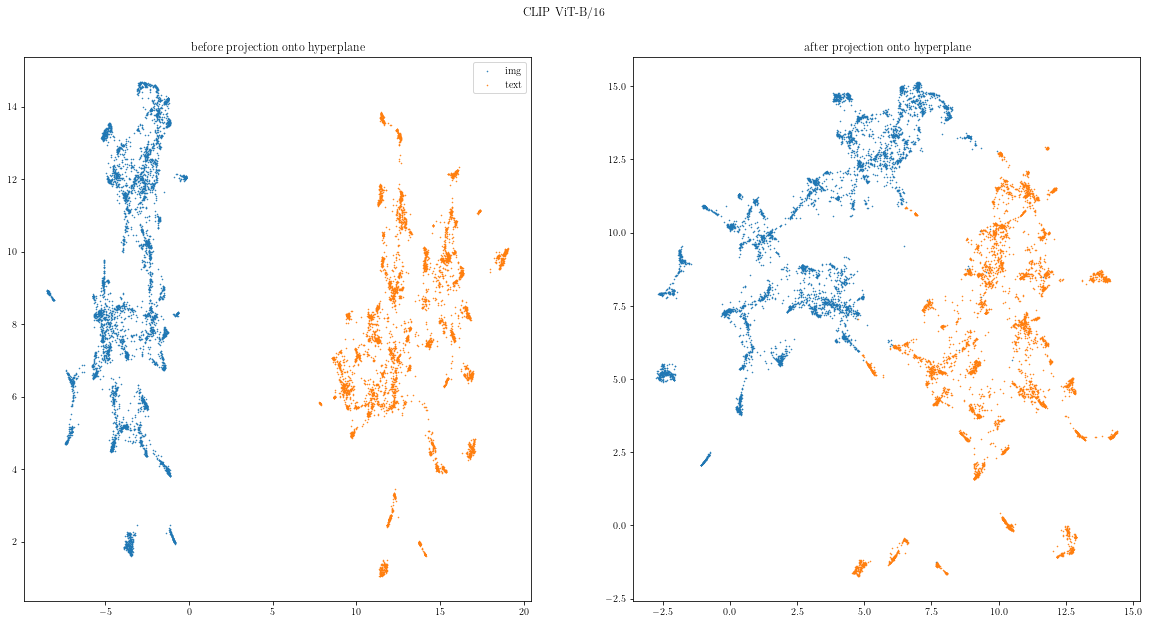

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), facecolor="white")

axes[0].scatter(umap[:len(img_embeds), 0], umap[:len(img_embeds), 1], s=0.3, label="img")
axes[0].scatter(umap[len(img_embeds):, 0], umap[len(img_embeds):, 1], s=0.3, label="text")
axes[0].set(title="before projection onto hyperplane")
axes[0].legend()
axes[1].scatter(u_after[:len(img_embeds), 0], u_after[:len(img_embeds), 1], s=0.3, label="img")
axes[1].scatter(u_after[len(img_embeds):, 0], u_after[len(img_embeds):, 1], s=0.3, label="text")

axes[1].set(title="after projection onto hyperplane")
plt.gcf().suptitle("CLIP ViT-B/16", y=0.95)

Text(0.5, 0.95, 'CLOOB ViT-B/16')

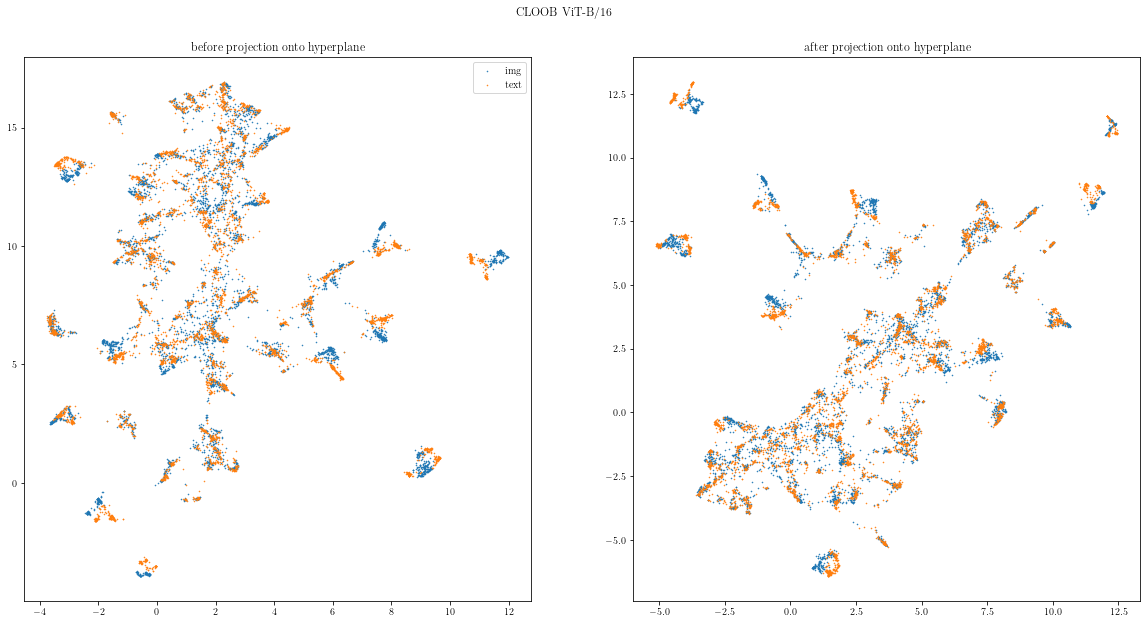

In [16]:
img_embeds, text_embeds = models["cloob ViT-B-16"]["img_embeds"][:5000], models["cloob ViT-B-16"]["text_embeds"][:5000]
umap, u_after = projected_embed(img_embeds, text_embeds)

fig, axes = plt.subplots(1, 2, figsize=(20, 10), facecolor="white")

axes[0].scatter(umap[:len(img_embeds), 0], umap[:len(img_embeds), 1], s=0.3, label="img")
axes[0].scatter(umap[len(img_embeds):, 0], umap[len(img_embeds):, 1], s=0.3, label="text")
axes[0].set(title="before projection onto hyperplane")
axes[0].legend()
axes[1].scatter(u_after[:len(img_embeds), 0], u_after[:len(img_embeds), 1], s=0.3, label="img")
axes[1].scatter(u_after[len(img_embeds):, 0], u_after[len(img_embeds):, 1], s=0.3, label="text")

axes[1].set(title="after projection onto hyperplane")
plt.gcf().suptitle("CLOOB ViT-B/16", y=0.95)